<a href="https://colab.research.google.com/github/Negfir/Deep-Learning-HWs/blob/main/HW1/DL_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import torch


In [2]:
from google.colab import drive
drive.mount('/content/gdrive' )

Mounted at /content/gdrive


In [3]:
%cd '/content/gdrive/My Drive/Dataset'


/content/gdrive/My Drive/Dataset


In [4]:
# Training Data
x_train = pd.read_csv('data/training_set.csv', header=None).values
x_train = torch.from_numpy(x_train.astype(float))
y_train = pd.read_csv('data/training_labels_bin.csv', header=None).values
y_train = torch.from_numpy(y_train.astype(float))
x_val = pd.read_csv('data/validation_set.csv', header=None).values
x_val = torch.from_numpy(x_val.astype(float))
y_val = pd.read_csv('data/validation_labels_bin.csv', header=None).values
y_val = torch.from_numpy(y_val.astype(float))
N = len(x_train)
x_train.shape


torch.Size([8442, 354])

In [5]:
start = time.time()

torch.manual_seed(6)

num_feats = x_train.shape[1]
n_out = y_train.shape[1]

# hyperparameters (you may change these)
eta = 0.1 # intial learning rate
gamma = 0.1 # multiplier for the learning rate
stepsize = 200 # epochs before changing learning rate
threshold = 0.08 # stopping criterion
test_interval = 10 # number of epoch before validating
max_epoch = 5

# Define Architecture of NN
# [ ] Intialize your network weights and biases here

#Network size
inputSize = x_train.shape[1]
outputSize = 3
hidden_1_Size = 8
hidden_2_Size = 8

W1= torch.rand((inputSize, hidden_1_Size), requires_grad=True)
W1 = 1 - (W1.float()*2)

W2= torch.rand((hidden_1_Size, hidden_2_Size), requires_grad=True)
W2 = 1 - (W2.float()*2)

W3= torch.rand((hidden_2_Size, outputSize), requires_grad=True)
W3 = 1 - (W3.float()*2)

def forward(x):
    h1 = torch.sigmoid(torch.matmul(x.float(),W1))
    h2 = torch.sigmoid(torch.matmul( h1, W2))
    y_pred = torch.sigmoid(torch.matmul(h2, W3))
    # y_pred = torch.where(y_pred > 0.5, 1, 0)
    return y_pred


def backward(self, X, y, o):
        self.o_error = y - o # error in output
        self.o_delta = self.o_error * self.sigmoidPrime(o) # derivative of sig to error
        self.z2_error = torch.matmul(self.o_delta, torch.t(self.W2))
        self.z2_delta = self.z2_error * self.sigmoidPrime(self.z2)
        self.W1 += torch.matmul(torch.t(X), self.z2_delta)
        self.W2 += torch.matmul(torch.t(self.z2), self.o_delta)

for epoch in range(0, max_epoch):
    
    order = np.random.permutation(N) # shuffle data
    
    sse = 0
    for n in range(0, N):
        idx = order[n]

        # get a sample (batch size=1)
        x_in = x_train[idx]
        y = y_train[idx]

        # [ ] do the forward pass here
        # hint: you need to save the output of each layer to calculate the gradients later
        forward(x_in)
    
        # [ ] compute error and gradients here
        # hint: don't forget the chain rule
               

        # [ ] update weights and biases here
        # update weights and biases in output layer 

    
        sse += 0 #squared_error

    #Accuracy
    acc = torch.sum(forward(x_train) == y_train)/float(len(y_train))
    print(f"Accuracy of Trial {epoch}: {acc}")


    train_mse = sse/len(x_train)

    # if epoch % test_interval == 0: 
    #     # [ ] test on validation set here

    #     # if termination condition is satisfied, exit
    #     if val_mse < threshold:
    #         break

    if epoch % stepsize == 0 and epoch != 0:
        eta = eta*gamma
        print('Changed learning rate to lr=' + str(eta))

Accuracy of Trial 0: 0.0
Accuracy of Trial 1: 0.0
Accuracy of Trial 2: 0.0
Accuracy of Trial 3: 0.0
Accuracy of Trial 4: 0.0


# **Trial**

In [6]:
# Training Data
x_train = pd.read_csv('data/training_set.csv', header=None).values
y_train = pd.read_csv('data/training_labels_bin.csv', header=None).values
x_val = pd.read_csv('data/validation_set.csv', header=None).values
y_val = pd.read_csv('data/validation_labels_bin.csv', header=None).values
N = len(x_train)
x_train.shape

(8442, 354)

In [187]:
start = time.time()

torch.manual_seed(6)

num_feats = x_train.shape[1]
n_out = y_train.shape[1]

# hyperparameters (you may change these)
eta = 0.005 # intial learning rate
gamma = 0.1 # multiplier for the learning rate
stepsize = 200 # epochs before changing learning rate
threshold = 0.08 # stopping criterion
test_interval = 10 # number of epoch before validating
max_epoch = 30

# Define Architecture of NN
# [ ] Intialize your network weights and biases here

#Network size
inputSize = x_train.shape[1]
outputSize = 3
hidden_1_Size = 16
hidden_2_Size = 8

W1= np.random.rand(inputSize, hidden_1_Size)
W1 = 1 - (W1*2)
b1 = np.random.randn(hidden_1_Size)

W2= np.random.rand(hidden_1_Size, hidden_2_Size)
W2 = 1 - (W2*2)
b2 = np.random.randn(hidden_2_Size)

W3= np.random.rand(hidden_2_Size, outputSize)
W3 = 1 - (W3*2)
b3 = np.random.randn(outputSize)

def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_der(x):
    return sigmoid(x) *(1-sigmoid (x))

def predict(x):
    h1 = sigmoid(np.matmul(x,W1)+b1)
    h2 = sigmoid(np.matmul( h1, W2)+b2)
    y_pred = sigmoid(np.matmul(h2, W3)+b3)
    y_pred = np.where(y_pred > 0.5, 1, 0)
    return y_pred

def accuracy(pred, y):
    acc=0
    for i,x in enumerate(pred):
      acc += np.sum(x == y[i])/float(len(y[i]))
    return acc/len(pred)


training_losses = []


for epoch in range(0, max_epoch):
    
    order = np.random.permutation(N) # shuffle data
    
    sse = 0
    for n in range(0, N):
        idx = order[n]

        # get a sample (batch size=1)
        x_in = x_train[idx]
        y = y_train[idx]

        # [ ] do the forward pass here
        # hint: you need to save the output of each layer to calculate the gradients later
        z1 = np.matmul(x_in,W1)+b1
        h1 = sigmoid(z1)
        z2 = np.matmul( h1, W2)+b2
        h2 = sigmoid(z2)
        z3 = np.matmul(h2, W3)+b3
        y_pred = sigmoid(z3)
    
        # [ ] compute error and gradients here
        # hint: don't forget the chain rule
        dsse_dy = np.sum(2*(y_pred - y))
        dy_dz3 = sigmoid_der(z3)
        dsse_dz3 = dsse_dy * dy_dz3
        dz3_dw3 = h2
        dsse_dw3 = np.dot(dsse_dz3.reshape(len(dsse_dz3),1),dz3_dw3.reshape(1,len(dz3_dw3)))
        dsse_db3 = np.dot(dsse_dy,dy_dz3)

        dz3_dh2 = W3
        dsse_dh2 = np.dot(dz3_dh2,dsse_dz3)
        dh2_dz2 = sigmoid_der(z2)
        dsse_dz2 = dh2_dz2 * dsse_dh2
        dz2_dw2 = h1
        dsse_dw2 = np.dot(dsse_dz2.reshape(len(dsse_dz2),1),dz2_dw2.reshape(1,len(dz2_dw2)))
        dsse_db2 = dh2_dz2 * dsse_dh2

        dz2_dh1 = W2
        dsse_dh1 = np.dot(dz2_dh1,dsse_dz2)
        dh1_dz1 = sigmoid_der(z1)
        dsse_dz1 = dh1_dz1 * dsse_dh1
        dz1_dw1 = x_in
        dsse_dw1 = np.dot(dsse_dz1.reshape(len(dsse_dz1),1),dz1_dw1.reshape(1,len(dz1_dw1)))
        dsse_db1 = dh1_dz1 * dsse_dh1



        # [ ] update weights and biases here
        # update weights and biases in output layer 
        W1 -= eta * dsse_dw1.T
        b1 -= eta * dsse_db1

        W2 -= eta * dsse_dw2.T
        b2 -= eta * dsse_db2

        W3 -= eta * dsse_dw3.T
        b3 -= eta * dsse_db3

    
        sse += np.sum((y_pred - y)**2) #squared_error
    training_losses.append(sse)
    #Accuracy
    acc = accuracy(predict(x_train),y_train)
    print(f"Accuracy of Trial {epoch}: {acc} ------ Loss= {sse/len(y_train)}")
    

    train_mse = sse/len(x_train)

    # if epoch % test_interval == 0: 
    #     # [ ] test on validation set here

    #     # if termination condition is satisfied, exit
    #     if val_mse < threshold:
    #         break

    if epoch % stepsize == 0 and epoch != 0:
        eta = eta*gamma
        print('Changed learning rate to lr=' + str(eta))

Accuracy of Trial 0: 0.5090420911316422 ------ Loss= 0.9822573347529615
Accuracy of Trial 1: 0.5119639895759279 ------ Loss= 0.930392012177188
Accuracy of Trial 2: 0.6357103372028785 ------ Loss= 0.7383816895672812
Accuracy of Trial 3: 0.659440890784188 ------ Loss= 0.6609801737377046
Accuracy of Trial 4: 0.670417752507325 ------ Loss= 0.647503236893287
Accuracy of Trial 5: 0.6833293848219415 ------ Loss= 0.6375099329146615
Accuracy of Trial 6: 0.6867251046355729 ------ Loss= 0.6263932940341685
Accuracy of Trial 7: 0.7010976861723378 ------ Loss= 0.614336931825223
Accuracy of Trial 8: 0.7056384742952178 ------ Loss= 0.6026341513298904
Accuracy of Trial 9: 0.7146015951986421 ------ Loss= 0.5921228933361494
Accuracy of Trial 10: 0.7142462291716346 ------ Loss= 0.583797792470509
Accuracy of Trial 11: 0.7162204848772343 ------ Loss= 0.5766947815473887
Accuracy of Trial 12: 0.7176024638711547 ------ Loss= 0.5712604466952078
Accuracy of Trial 13: 0.7165363657901306 ------ Loss= 0.56719083993

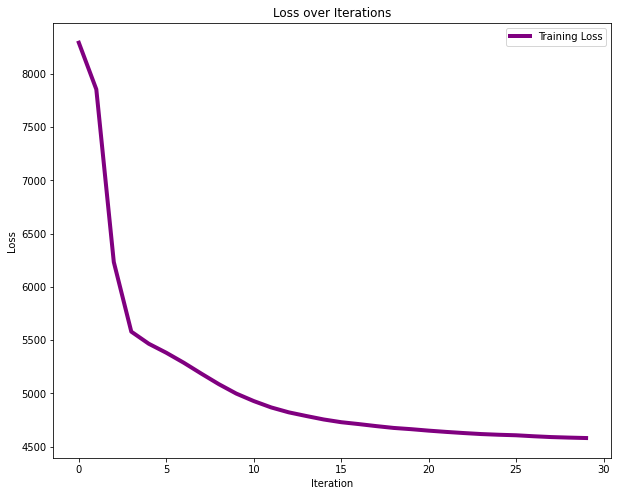

In [188]:
plt.figure(figsize=(10,8))
plt.plot(training_losses, lw=4, color='purple', label='Training Loss')

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss over Iterations')
plt.legend()